In [1]:
from quantum_permutation_utils import * 

##### #Permutation routines 

In [2]:
def bit_conditional( num: int, qc: QuantumCircuit, register: QuantumRegister): ## @helper_function
    """ helper function to assist the conditioning of ancillas for generating permutations
    
        ARGS:
            num : the integer to be conditioned upon 
            qc : QuantumCircuit of the original circuit
            register : QuantumRegister corresponding to the ancilla which is conditioned upon 
        
        RETURNS:
            Works inplace i.e modifies the original circuit 'qc' that was passed 
            
    """

    n = len(register)
    bin_str = format(num, "b").zfill(n)
    assert len(bin_str) == len(register)            ## need to assurethe bit ordering covention according tto qiskit's

    bin_str = bin_str[::-1]                         ## reverse the bit string
    for index, bit in enumerate(bin_str):
        if bit== '0': qc.x(register[index]) 
        

In [3]:
def generate_permutation_operators(num_bits:int , power:int= 1)-> QuantumCircuit :
    """ Function to generate the permutaion operators 
    
        ARGS:
            num_bits : no. of elements in the permutation set
            power : power of the permuation operator
            
        RETURNS:
            QuantumCircuit implementing the permutation operator
    """

    if num_bits < 2 : raise ValueError(" 'num_bits' must be greater than or equal to 2 ") 
    if power not in list(range(num_bits)) : raise ValueError(" 'power' must be such that ; 0 <= 'power' < 'num_bits'  ")

    qreg = QuantumRegister(num_bits, name= 'qreg')
    qc = QuantumCircuit(qreg)

    for rep in range(power):    
        for qubit in range(num_bits-1):
            qc.swap(qubit, qubit+1)

    return qc.to_gate(label= 'P_'+str(num_bits)+'('+str(power)+')')



##### #Trials

In [56]:
n = 3
qreg = QuantumRegister(n, name= 'msg')
# creg = ClassicalRegister(n, name= 'creg')
controls = [QuantumRegister( math.ceil(np.log2(j))  , name= 'controls '+str(j)+':' ) for j in range(2, n+1)  ]

qc = QuantumCircuit(qreg)
for ancilla in controls: 
    qc.add_register(ancilla)

# ancilla_qubit = QuantumRegister(1, name= 'ancilla')
# qc.add_register(ancilla_qubit)   

## state initialisation ~

qc.x(0)
# qc.x(2)
# qc.x(3)
# qc.x(4)
qc.x(1)

qc.barrier()

In [59]:
## initialise the controls
for control in controls:
    qc.h(control)
qc.barrier()

In [60]:
for permutation_operator in range(2,n+1):

    permutation_size = permutation_operator
    control = controls[ permutation_size - 2  ]
    permutation_operators_n = [ generate_permutation_operators(permutation_size ,power= k) for k in range(0, permutation_size) ]

    for power in range(0, permutation_size):
        bit_conditional(power, qc, control)
        qc.append(permutation_operators_n[power].control(len(control)), [ control[i] for i in range(len(control))  ] + [ qreg[i] for i in range(permutation_size) ]  )
        bit_conditional(power, qc, control)
        qc.barrier()

In [65]:
ancill = AncillaRegister(1, name='ancilla')
qc.add_register(ancill)

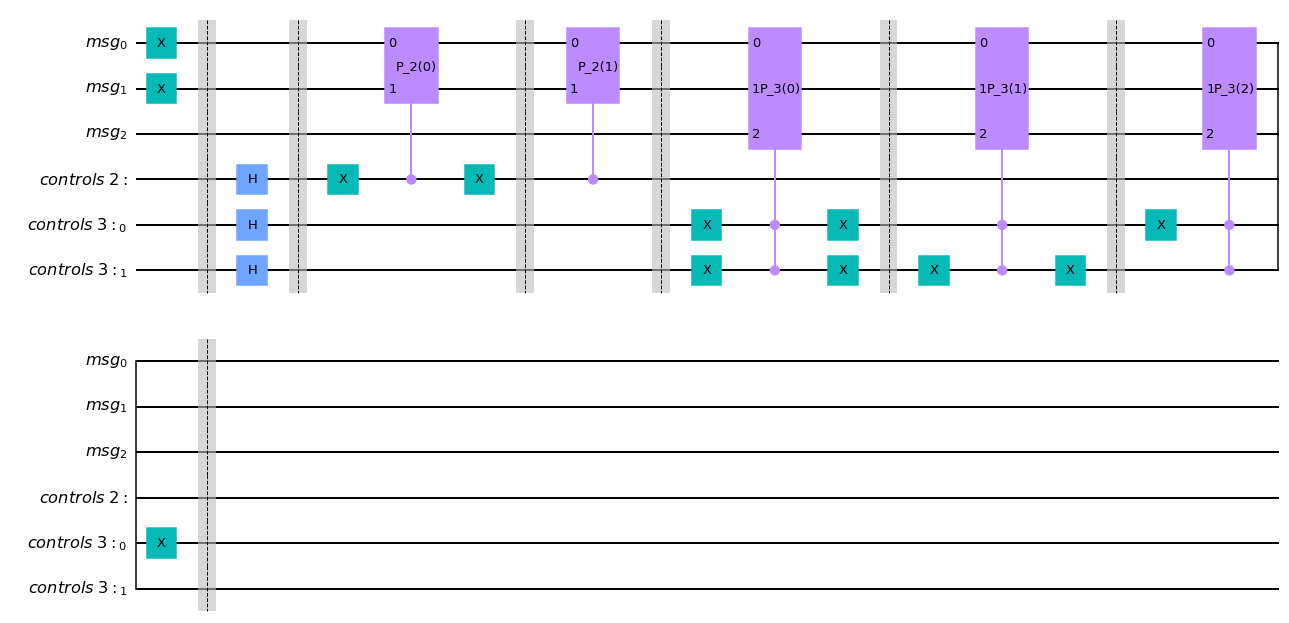

In [61]:
qc.draw(output= 'mpl')

In [71]:
result = measure_and_plot(qc, shots= 2000, show_counts= True, measure_cntrls= True, return_counts= True, cntrl_specifier= 'all' ) 

str
{'key: 0 1 0 -> 110': 243, 'key: 0 3 1 -> 101': 48, 'key: 0 0 0 -> 101': 63, 'key: 0 3 0 -> 101': 59, 'key: 0 2 1 -> 101': 58, 'key: 0 2 0 -> 110': 270, 'key: 0 2 0 -> 101': 71, 'key: 0 2 1 -> 110': 265, 'key: 0 2 1 -> 011': 238, 'key: 0 1 1 -> 110': 257, 'key: 0 0 1 -> 101': 62, 'key: 0 2 0 -> 011': 237, 'key: 0 1 0 -> 101': 63, 'key: 0 1 1 -> 101': 66}


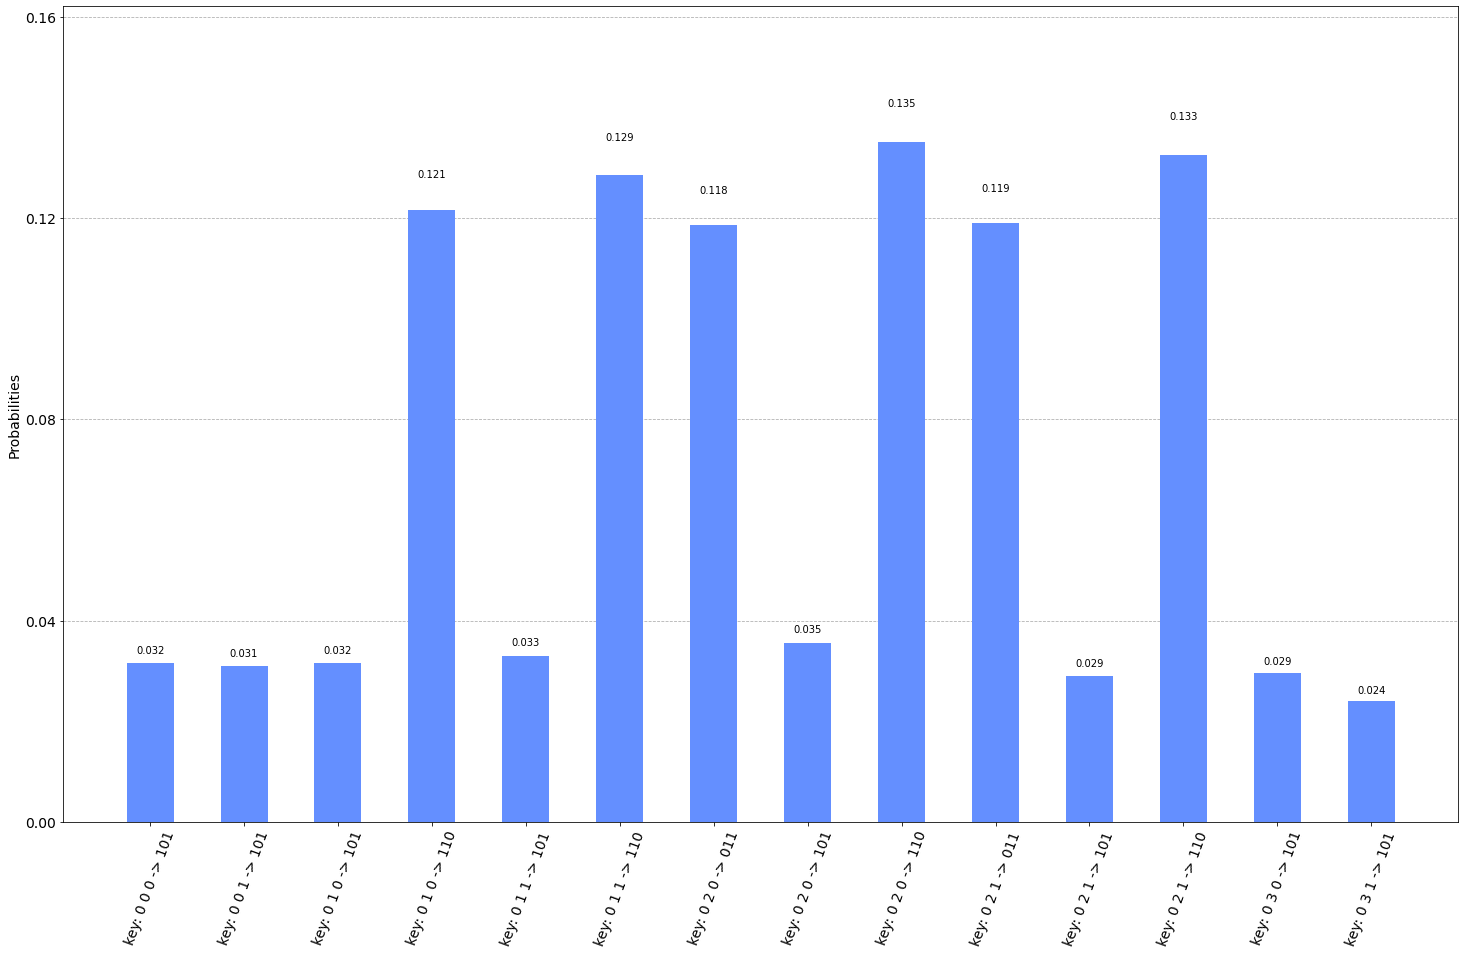

In [72]:
plot_histogram(result, figsize= (25,15))

In [58]:
global mapping
mapping = cntrl_to_operator_map(controls)
encryption_key = { controls[0]:1, controls[1]:2}
# qc_p = permute_using_key(encryption_key, qreg,  qc, mapping)
# # qc_p.draw(output='mpl')
# measure_and_plot(qc,measure_cntrls=True, return_counts= True ,cntrl_specifier= 'all')

In [66]:
good_key = ''
for cntrl in controls:
    if cntrl in encryption_key.keys():
        power = encryption_key[cntrl]
        n = len(cntrl)
        bin_power = format(power, 'b').zfill(n)
        good_key+= bin_power[::-1]
    
    else :
        n = len(cntrl)
        bin_power = '0'*n
        good_key+= bin_power

good_key

'101'

In [68]:
grv.draw()

░ ┌───┐┌───┐     ┌───┐┌───┐
  reg_0: ────────────■─────────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
         ┌───┐       │  ┌───┐      ░ ├───┤├───┤  │  ├───┤├───┤
  reg_1: ┤ X ├───────■──┤ X ├──────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
         └───┘       │  └───┘      ░ ├───┤├───┤  │  ├───┤├───┤
  reg_2: ────────────■─────────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
         ┌───┐┌───┐┌─┴─┐┌───┐┌───┐ ░ ├───┤├───┤┌─┴─┐├───┤├───┤
ancilla: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├─░─┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├
         └───┘└───┘└───┘└───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘

In [67]:

grv = grover([good_key], insert_barrier= True )


In [69]:
qc.append( grv , qc.qubits[3:])

In [12]:
result = measure_and_plot(qc, shots= 2000, show_counts= False, measure_cntrls= True, return_counts= True, cntrl_specifier= 'all' ) 

str


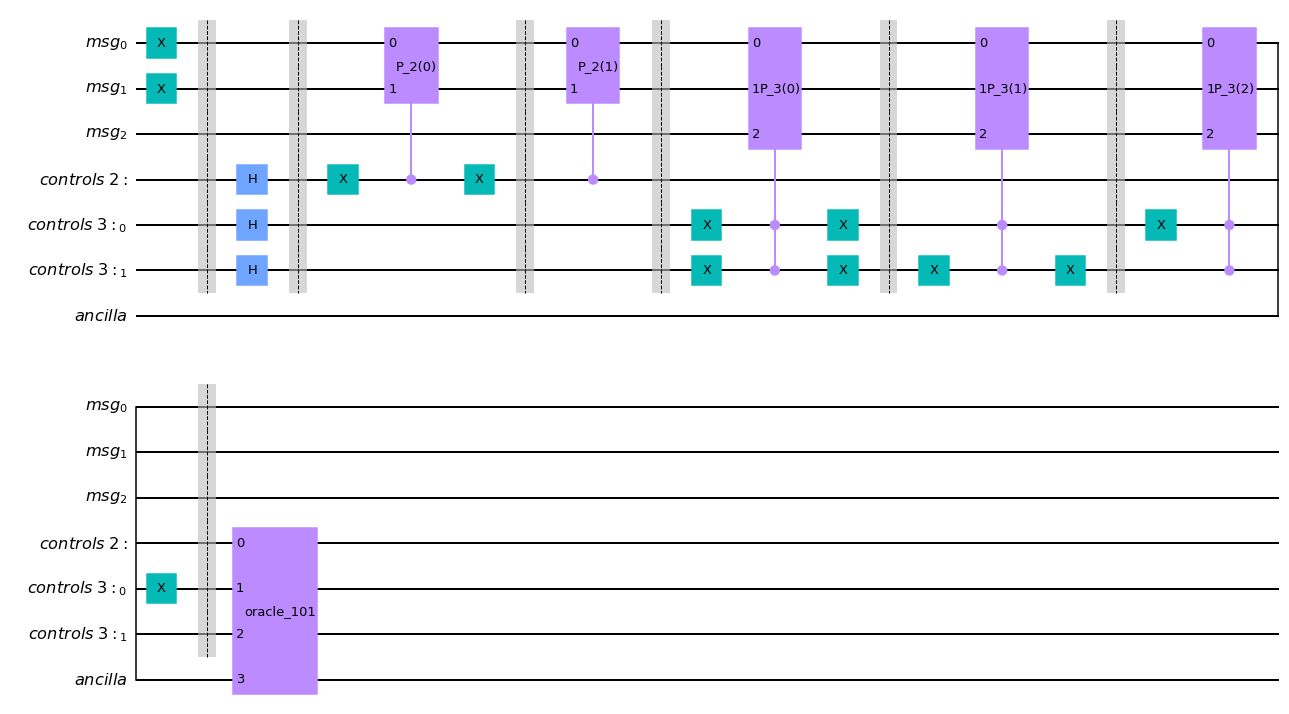

In [70]:
qc.draw(output= 'mpl')

#### scratch

In [19]:
s = '120'
int(list(s)[1])

encryption_key = '61242'
elements = list(encryption_key[::-1])
dictionary = dict( [ ( controls[j], int(element) ) for j, element in enumerate(elements)  ] )


In [20]:
dictionary

{QuantumRegister(1, 'controls 2:'): 2,
 QuantumRegister(2, 'controls 3:'): 4,
 QuantumRegister(2, 'controls 4:'): 2,
 QuantumRegister(3, 'controls 5:'): 1,
 QuantumRegister(3, 'controls 6:'): 6}

In [14]:
control

QuantumRegister(3, 'controls 8:')

In [15]:
dic = {}
dic[control] = '2'
dic

{QuantumRegister(3, 'controls 8:'): '2'}

In [16]:
measure_and_plot(qc, show_counts= True, measure_ancilla= True, return_counts= False, ancilla_specifier= [2] ) 

TypeError: measure_and_plot() got an unexpected keyword argument 'measure_ancilla'

In [ ]:
isinstance([1,2], int)

False

In [ ]:
str_c= '10 1 10101'
strs = str_c.split(' ')
str_m = ''
for string in strs[:-1]: 
    str_m += str(int(string, 2)) + ' '
str_m += strs[-1]

In [ ]:
d = {1:2, 2: 3}
d+= ({3:4})
dict

TypeError: unsupported operand type(s) for +=: 'dict' and 'dict'

In [ ]:
%run quantum_permutation_utils.py
from quantum_permutation_utils import *

In [ ]:
## post state selecetion ~
good_state = '01'
or_c = str_to_oracle(good_state)
grv_c = GroverOperator(or_c, name= 'grover_'+ good_state)

# qc.append(grv_c, [ controls[1][0], controls[1][1], ancilla_qubit  ])
# qc.compose( grv_c, [ controls[1][0], controls[1][1], ancilla_qubit  ] , inplace= True)
# qc.draw()

In [ ]:
good_states = ['01']
grv = grover(good_states, insert_barrier= True)
# grv.draw()

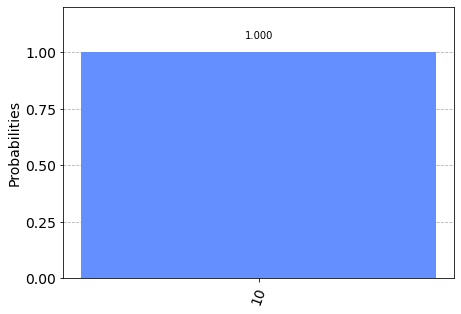

<Figure size 432x288 with 0 Axes>

In [ ]:
qr = QuantumRegister(2)
a = QuantumRegister(1)
q = QuantumCircuit(qr, a)
q.h(qr)
q.compose(grv, inplace= True)
q.draw()
measure_and_plot(q)

In [ ]:
qc.append(grv, [ controls[1][0], controls[1][1], ancilla_qubit  ])
qc.draw()

░       ░      ┌─────────┐      ░      ┌─────────┐      ░      »
       qreg_0: ─░───────░──────┤0        ├──────░──────┤0        ├──────░──────»
                ░ ┌───┐ ░      │         │      ░      │         │      ░      »
       qreg_1: ─░─┤ X ├─░──────┤1 P_3(0) ├──────░──────┤1 P_3(1) ├──────░──────»
                ░ ├───┤ ░      │         │      ░      │         │      ░      »
       qreg_2: ─░─┤ X ├─░──────┤2        ├──────░──────┤2        ├──────░──────»
                ░ ├───┤ ░      └────┬────┘      ░      └────┬────┘      ░      »
  controls 2:: ─░─┤ H ├─░───────────┼───────────░───────────┼───────────░──────»
                ░ ├───┤ ░ ┌───┐     │     ┌───┐ ░           │           ░ ┌───┐»
controls 3:_0: ─░─┤ H ├─░─┤ X ├─────■─────┤ X ├─░───────────■───────────░─┤ X ├»
                ░ ├───┤ ░ ├───┤     │     ├───┤ ░ ┌───┐     │     ┌───┐ ░ └───┘»
controls 3:_1: ─░─┤ H ├─░─┤ X ├─────■─────┤ X ├─░─┤ X ├─────■─────┤ X ├─░──────»
                ░ └───┘ ░ └───┘           └───┘ ░ └───┘           └───┘ ░      »
      ancilla: ─░───────░───────────────────────░───────────────────────░──────»
                ░       ░                       ░                       ░      »
«               ┌─────────┐      ░                             
«       qreg_0: ┤0        ├──────░─────────────────────────────
«               │         │      ░                             
«       qreg_1: ┤1 P_3(2) ├──────░─────────────────────────────
«               │         │      ░                             
«       qreg_2: ┤2        ├──────░─────────────────────────────
«               └────┬────┘      ░                             
«  controls 2:: ─────┼───────────░─────────────────────────────
«                    │     ┌───┐ ░ ┌────────────┐┌────────────┐
«controls 3:_0: ─────■─────┤ X ├─░─┤0           ├┤0           ├
«                    │     └───┘ ░ │            ││            │
«controls 3:_1: ─────■───────────░─┤1 oracle_01 ├┤1 oracle_01 ├
«                                ░ │            ││            │
«      ancilla: ─────────────────░─┤2           ├┤2           ├
«                                ░ └────────────┘└────────────┘

{'01 101': 55, '11 011': 67, '00 011': 68, '01 011': 71, '10 101': 62, '11 101': 64, '10 110': 246, '00 101': 70, '10 011': 67, '01 110': 254}


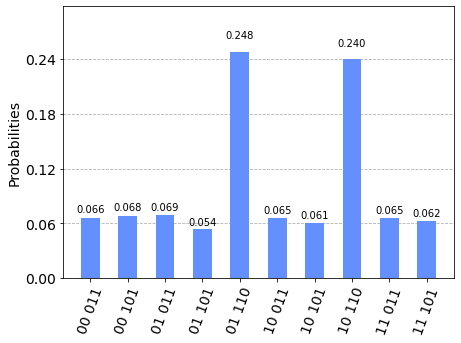

<Figure size 432x288 with 0 Axes>

In [ ]:
measure_and_plot(qc, show_counts= True, measure_ancilla= True, ancilla_specifier= 2 )

In [ ]:
projector_0 = Statevector.from_label('0').to_operator()
unitary_0 = HamiltonianGate(projector_0, pi)
qc.append(unitary_0, an )
qc.draw()

NameError: name 'an' is not defined

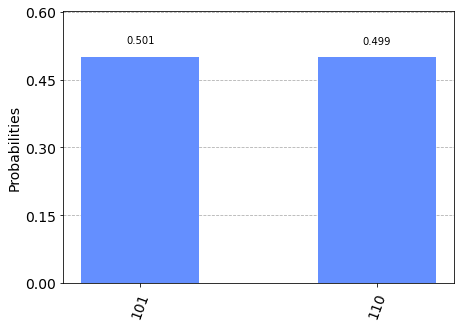

<Figure size 432x288 with 0 Axes>

In [ ]:
measure_and_plot(qc)

In [ ]:
# for permutation_operator in range(2,n+1):
permutation_size = 2
ancilla = ancillas[ permutation_size - 2  ]
permutation_operators_n = [ generate_permutation_operators(permutation_size ,power= k) for k in range(0, permutation_size) ]

for power in range(0, permutation_size):
    bit_conditional(power, qc, ancilla)
    qc.append(permutation_operators_n[power].control(len(ancilla)), [ ancilla[i] for i in range(len(ancilla))  ] + [ qreg[i] for i in range(permutation_size) ]  )
    bit_conditional(power, qc, ancilla)
    qc.barrier()
# qc.compose(permutation_operators_n[1], inplace= True)

qc.draw()

░ ┌───┐ ░      ┌─────────┐      ░      ┌─────────┐      ░      »
       qreg_0: ─░─┤ X ├─░──────┤0        ├──────░──────┤0        ├──────░──────»
                ░ └───┘ ░      │         │      ░      │         │      ░      »
       qreg_1: ─░───────░──────┤1 P_3(0) ├──────░──────┤1 P_3(1) ├──────░──────»
                ░       ░      │         │      ░      │         │      ░      »
       qreg_2: ─░───────░──────┤2        ├──────░──────┤2        ├──────░──────»
                ░ ┌───┐ ░      └────┬────┘      ░      └────┬────┘      ░      »
  controls 2:: ─░─┤ H ├─░───────────┼───────────░───────────┼───────────░──────»
                ░ ├───┤ ░ ┌───┐     │     ┌───┐ ░           │           ░ ┌───┐»
controls 3:_0: ─░─┤ H ├─░─┤ X ├─────■─────┤ X ├─░───────────■───────────░─┤ X ├»
                ░ ├───┤ ░ ├───┤     │     ├───┤ ░ ┌───┐     │     ┌───┐ ░ └───┘»
controls 3:_1: ─░─┤ H ├─░─┤ X ├─────■─────┤ X ├─░─┤ X ├─────■─────┤ X ├─░──────»
                ░ └───┘ ░ └───┘           └───┘ ░ └───┘           └───┘ ░      »
«               ┌─────────┐      ░      ┌─────────┐      ░ ┌─────────┐ ░ 
«       qreg_0: ┤0        ├──────░──────┤0        ├──────░─┤0        ├─░─
«               │         │      ░      │  P_2(0) │      ░ │  P_2(1) │ ░ 
«       qreg_1: ┤1 P_3(2) ├──────░──────┤1        ├──────░─┤1        ├─░─
«               │         │      ░      └────┬────┘      ░ └────┬────┘ ░ 
«       qreg_2: ┤2        ├──────░───────────┼───────────░──────┼──────░─
«               └────┬────┘      ░ ┌───┐     │     ┌───┐ ░      │      ░ 
«  controls 2:: ─────┼───────────░─┤ X ├─────■─────┤ X ├─░──────■──────░─
«                    │     ┌───┐ ░ └───┘           └───┘ ░             ░ 
«controls 3:_0: ─────■─────┤ X ├─░───────────────────────░─────────────░─
«                    │     └───┘ ░                       ░             ░ 
«controls 3:_1: ─────■───────────░───────────────────────░─────────────░─
«                                ░                       ░             ░

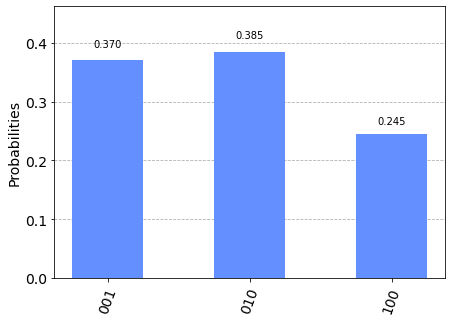

<Figure size 432x288 with 0 Axes>

In [ ]:
measure_and_plot(qc)

In [ ]:
[ ancilla[i] for i in range(len(ancilla))] + [qreg[i] for i in range(len(qreg))]

[Qubit(QuantumRegister(2, 'controls 3:'), 0),
 Qubit(QuantumRegister(2, 'controls 3:'), 1),
 Qubit(QuantumRegister(5, 'qreg'), 0),
 Qubit(QuantumRegister(5, 'qreg'), 1),
 Qubit(QuantumRegister(5, 'qreg'), 2),
 Qubit(QuantumRegister(5, 'qreg'), 3),
 Qubit(QuantumRegister(5, 'qreg'), 4)]

In [ ]:
creg = ClassicalRegister(1, name= 'creg1')


In [ ]:
shots= 100024
for i in range(5):
    qc1 = qc.copy()
    qc1.add_register(creg) 
    qc1.measure(i, creg)
    shots = 1024
    cnts = execute(qc1, backend= qsm, shots= shots).result().get_counts()
    print('i= ', i, ' :', round(cnts['1']*10/shots))

i=  0  : 2
i=  1  : 2
i=  2  : 2
i=  3  : 3
i=  4  : 5


In [ ]:
shots= 50024
for i in range(5):
    qc1 = qc.copy()
    qc1.add_register(creg) 
    qc1.measure(i, creg)
    shots = 1024
    cnts = execute(qc1, backend= qsm, shots= shots).result().get_counts()
    print('i= ', i, ' :', cnts['1']/shots)

i=  0  : 0.234375
i=  1  : 0.263671875
i=  2  : 0.265625
i=  3  : 0.2412109375
i=  4  : 0.5068359375


In [ ]:
x = np.array([ 2*pi*(i/n) for i in range(n)])
np.cos(x)

array([ 1.        ,  0.30901699, -0.80901699, -0.80901699,  0.30901699])

In [ ]:
measure_phase(qc)

{'0': 10024}
{'1': 3469, '0': 6555}
{'0': 924, '1': 9100}
{'0': 879, '1': 9145}
{'0': 6579, '1': 3445}


array([ 1.        ,  0.30786113, -0.81564246, -0.82462091,  0.31264964])

In [ ]:
def measure_phase(qc: QuantumCircuit, qubit: Union[int, Qubit, str]= 'all' , shots= 10024  ):
    n = qc.num_qubits - qc.num_ancillas
    phases = np.zeros(n)
    if qubit == 'all':s
        for i in range(n):
            qc_t = qc.copy()
            creg_internal = ClassicalRegister(1)
            qc_t.add_register(creg_internal)

            qc_t.measure(i, creg_internal)
            qc_t.draw()
            counts = execute(qc_t, backend= qsm, shots= shots ).result().get_counts()
            print(counts)
            p0 = counts['0']/shots
            phases[i] = 2 * (p0 - 1/2) 
    
    return phases

##### #State Reconstruction 

In [ ]:
## check hadamard test 

qreg = QuantumRegister(1, name= 'reg')
one = QuantumRegister(1, name= 'one')
ancilla = QuantumRegister(1, name= 'ancilla')

creg = ClassicalRegister(1, name= 'creg')
qc = QuantumCircuit(qreg, one, ancilla, creg)

p = (2)/10
theta = 2*np.arcsin(np.sqrt(p))
qc.ry(theta, qreg)
qc.x(one)

qc.barrier()

In [ ]:
qc.h(ancilla)
qc.cswap(ancilla, one, qreg)
qc.h(ancilla)
qc.barrier()

In [ ]:
qc.measure(ancilla, creg)
qc.barrier()

In [ ]:
qc.swap(one,qreg).c_if(creg, 1)

In [ ]:
qc.draw()

┌────────────┐ ░               ░     ░        
    reg: ┤ Ry(0.9273) ├─░───────X───────░─────░────X───
         └───┬───┬────┘ ░       │       ░     ░    │   
    one: ────┤ X ├──────░───────X───────░─────░────X───
             └───┘      ░ ┌───┐ │ ┌───┐ ░ ┌─┐ ░    ║   
ancilla: ───────────────░─┤ H ├─■─┤ H ├─░─┤M├─░────╫───
                        ░ └───┘   └───┘ ░ └╥┘ ░ ┌──╨──┐
 creg: 1/══════════════════════════════════╩════╡ 0x1 ╞
                                           0    └─────┘

In [ ]:
shots= 10024
counts = execute(qc, backend= qsm, shots= shots).result().get_counts()

In [ ]:
2*counts['1']/shots - 1

-0.19154030327214688

In [ ]:
qc_or = str_to_oracle('1')
gop = GroverOperator( qc_or , name= 'grover', insert_barriers= False)

In [ ]:
gop.draw()

┌────┐
  state: ┤0   ├
         │  Q │
ancilla: ┤1   ├
         └────┘

In [ ]:
qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()

qc.compose(gop, [0], inplace= True)
# qc.compose(gop, inplace= True)

qc.draw()

CircuitError: "Trying to compose with another QuantumCircuit which has more 'in' edges."

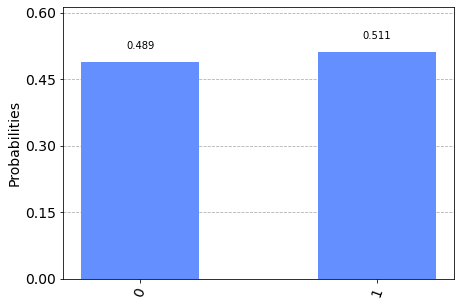

<Figure size 432x288 with 0 Axes>

In [ ]:
measure_and_plot(qc)

In [ ]:
gop.oracle.decompose().draw()

global phase: π/2
   ┌──────────┐
q: ┤ Ucrz(-π) ├
   └──────────┘